In [63]:
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection, preprocessing
np.random.seed(597)
tf.random.set_seed(597)
tf.config.list_physical_devices('GPU')

[]

In [65]:
# Fashion MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Split validation set
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=10000, random_state=597)
X_train = tf.reshape(X_train, (50000, 784))
X_val = tf.reshape(X_val, (10000, 784))
X_test = tf.reshape(X_test, (10000, 784))
assert X_train.shape == (50000, 784)
assert X_val.shape == (10000, 784)
assert X_test.shape == (10000, 784)
assert y_train.shape == (50000,)
assert y_val.shape == (10000,)
assert y_test.shape == (10000,)

6


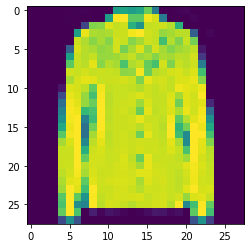

In [66]:
# Take a look at the first digit
print(y_train[0])
plt.imshow(tf.reshape(X_train[0], (28, 28)))

In [67]:
# Set hidden layer size
size_input = 784
size_hidden1 = 300
size_hidden2 = 100
size_output = 10
number_of_train_examples = 50000
number_of_val_examples = 10000
number_of_test_examples = 10000

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(20)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(10)

In [82]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_output, lr=1e-3, reg=None, dropout=None, normal=False):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of hidden layer1
    size_hidden2: int, size of hidden layer2
    size_output: int, size of output layer
    lr: float, learning rate for optimizer
    reg: list, penalty. e.g. ['l1']
    dropout: float, dropout rate
    normal: bool, whether normalize the data
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.lr, self.reg, self.dropout, self.normal =\
    size_input, size_hidden1, size_hidden2, size_output, lr, reg, dropout, normal
    
    # Initialize weights between input layer and hidden layer 1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize biases for hidden layer 1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
    # Initialize weights between hidden layer 1 and hidden layer 2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer 2
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
     # Initialize weights between hidden layer 2 and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    Always use gpu
    """
    with tf.device('gpu:0'):
        self.y = self.compute_output(X)
        
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.int32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # Use softmax categorical cross entropy for classification task
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
    if self.reg != None:
        if self.reg == ['l1']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
        elif self.reg == ['l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        elif self.reg == ['l1', 'l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables])) +\
                          1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        else:
            assert 1==0, "The parameters of regularization is unknown, please use ['l1'] or ['l1', 'l2']"
    # Add l1 reg
    return  loss 
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
    with tf.GradientTape() as tape:
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train) 
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Add normalization
    if self.normal == True:
        X_tf = X_tf/255.0
    # Add dropout
    if self.dropout != None:     
        X_tf = tf.nn.dropout(X_tf, rate = self.dropout, seed = 597)
    # Compute values in hidden layer 1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer 2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # softmax is applied in the calculation of cross entropy
    return output

In [111]:
def train(trail):
    # Set number of epochs
    NUM_EPOCHS = 10
    # Set seed
    np.random.seed(trail*597)
    tf.random.set_seed(trail*597)
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=10000, random_state=trail*597)
    X_train = tf.reshape(X_train, (50000, 784))
    X_val = tf.reshape(X_val, (10000, 784))
    X_test = tf.reshape(X_test, (10000, 784))
    # Initialize model using GPU
    mlp = MLP(size_input, size_hidden1, size_hidden2, size_output, lr=0.0005, normal=True, reg=['l2'])#, dropout=0.1)

    time_start = time.time()
    training_df = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
    for epoch in range(NUM_EPOCHS):
        loss_total = tf.zeros([1,1], dtype=tf.float32)
        lt = 0
        acc = []
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(trail*597)).batch(20)
        for inputs, outputs in (train_ds):
            preds = mlp.forward(inputs)
            loss_total = loss_total + mlp.loss(preds, outputs)
            lt = lt + mlp.loss(preds, outputs)
            acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
            mlp.backward(inputs, outputs)
        avg_loss = np.sum(loss_total) / X_train.shape[0]
        avg_acc = np.mean(acc)
        training_df.loc[epoch, ['epoch', 'train_loss', 'train_accuracy']] = [epoch + 1, avg_loss, avg_acc]
        print('Number of Epoch = {} - Average cross entropy:= {:.4f}'.format(epoch + 1, avg_loss),
              '\n                    - Average accuracy:= {:.4f}'.format(avg_acc))
        # validation for each epoch
        val_loss_total = tf.Variable(0, dtype=tf.float32)
        val_acc = []
        for inputs, outputs in val_ds:
            preds = mlp.forward(inputs)
            val_loss_total = val_loss_total + mlp.loss(preds, outputs)
            val_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
        val_avg_loss = np.sum(val_loss_total) / X_val.shape[0]
        val_avg_acc = np.mean(val_acc)
        training_df.loc[epoch, ['val_loss', 'val_accuracy']] = [val_avg_loss, val_avg_acc]

    time_taken = time.time() - time_start

    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
    
    return mlp

In [ ]:
mlp = train(1)

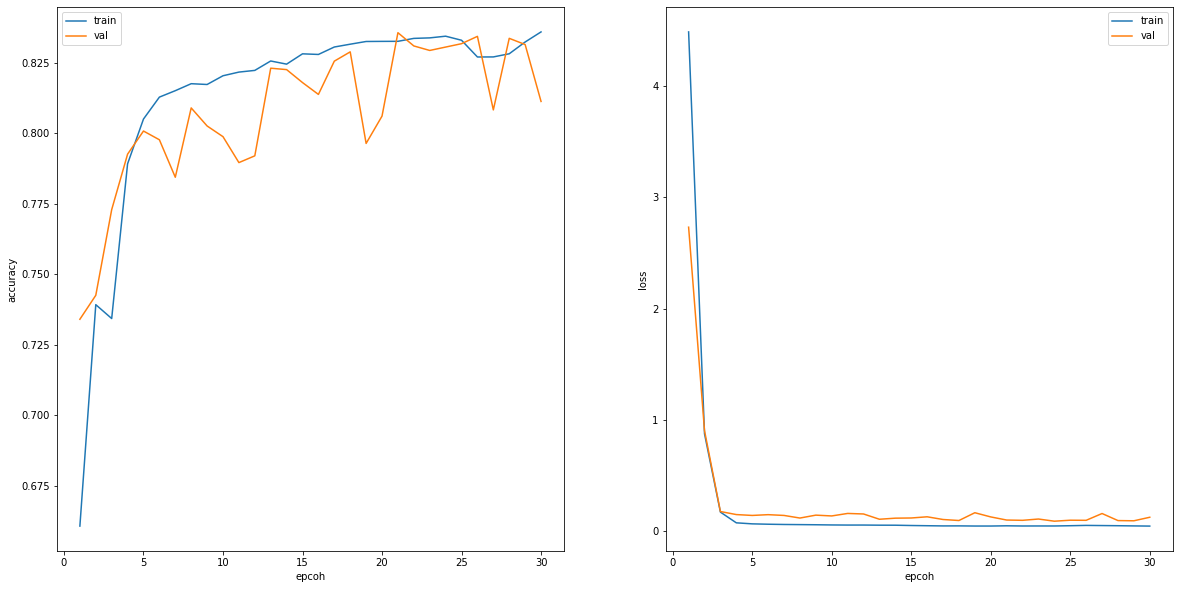

In [103]:
# Plot train validation error
f = plt.figure(figsize=(20, 10))
ax1 = f.add_subplot(121, xlabel = 'epcoh', ylabel = 'accuracy')
ax2 = f.add_subplot(122, xlabel = 'epcoh', ylabel = 'loss')
ax1.plot(training_df['epoch'], training_df['train_accuracy'], label = 'train')
ax1.plot(training_df['epoch'], training_df['val_accuracy'], label = 'val')
ax1.legend()
ax2.plot(training_df['epoch'], training_df['train_loss'], label = 'train')
ax2.plot(training_df['epoch'], training_df['val_loss'], label = 'val')
ax2.legend()

In [108]:
# Validation
val_loss_total = tf.Variable(0, dtype=tf.float32)
val_acc = []
for inputs, outputs in val_ds:
    preds = mlp.forward(inputs)
    val_loss_total = val_loss_total + mlp.loss(preds, outputs)
    val_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
val_avg_loss = np.sum(val_loss_total) / X_val.shape[0]
val_avg_acc = np.mean(val_acc)
print('Validation cross entropy: {:.4f}'.format(val_avg_loss),
      '\nTest accuracy:= {:.4f}'.format(val_avg_acc))

Validation cross entropy: 0.1229 
Test accuracy:= 0.8113


In [112]:
# Test
testing_df = pd.DataFrame(columns = ['trail', 'accuracy', 'loss'])
for trail in range(10):
    mlp = train(trail+1)
    test_loss_total = tf.Variable(0, dtype=tf.float32)
    test_acc = []
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=(trail*597)).batch(10)
    for inputs, outputs in test_ds:
        preds = mlp.forward(inputs)
        test_loss_total = test_loss_total + mlp.loss(preds, outputs)
        test_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
    test_avg_loss = np.sum(test_loss_total) / X_test.shape[0]
    test_avg_acc = np.mean(test_acc)
    testing_df.loc[trail] = [trail+1, test_avg_acc, test_avg_loss]
    print('Test cross entropy: {:.4f}'.format(test_avg_loss),
          '\nTest accuracy:= {:.4f}'.format(test_avg_acc))

Number of Epoch = 1 - Average cross entropy:= 4.7452 
                    - Average accuracy:= 0.6653
Number of Epoch = 2 - Average cross entropy:= 1.3084 
                    - Average accuracy:= 0.7520
Number of Epoch = 3 - Average cross entropy:= 0.6999 
                    - Average accuracy:= 0.7576
Number of Epoch = 4 - Average cross entropy:= 0.4348 
                    - Average accuracy:= 0.7649
Number of Epoch = 5 - Average cross entropy:= 0.2967 
                    - Average accuracy:= 0.7699
Number of Epoch = 6 - Average cross entropy:= 0.2238 
                    - Average accuracy:= 0.7781
Number of Epoch = 7 - Average cross entropy:= 0.1780 
                    - Average accuracy:= 0.7809
Number of Epoch = 8 - Average cross entropy:= 0.1523 
                    - Average accuracy:= 0.7837
Number of Epoch = 9 - Average cross entropy:= 0.1403 
                    - Average accuracy:= 0.7812
Number of Epoch = 10 - Average cross entropy:= 0.1441 
                    - Avera

Number of Epoch = 6 - Average cross entropy:= 0.0620 
                    - Average accuracy:= 0.7922
Number of Epoch = 7 - Average cross entropy:= 0.0583 
                    - Average accuracy:= 0.8024
Number of Epoch = 8 - Average cross entropy:= 0.0560 
                    - Average accuracy:= 0.8117
Number of Epoch = 9 - Average cross entropy:= 0.0552 
                    - Average accuracy:= 0.8144
Number of Epoch = 10 - Average cross entropy:= 0.0544 
                    - Average accuracy:= 0.8195

Total time taken (in seconds): 629.27
Test cross entropy: 0.1215 
Test accuracy:= 0.8177
Number of Epoch = 1 - Average cross entropy:= 5.0050 
                    - Average accuracy:= 0.6762
Number of Epoch = 2 - Average cross entropy:= 1.3992 
                    - Average accuracy:= 0.7568
Number of Epoch = 3 - Average cross entropy:= 0.8108 
                    - Average accuracy:= 0.7654
Number of Epoch = 4 - Average cross entropy:= 0.5384 
                    - Average accuracy:

In [120]:
print('average test accuracy: ', round(testing_df['accuracy'].mean(), 4))
print('accuracy standard error: ', round(np.std(testing_df['accuracy']), 4))
testing_df

average test accuracy:  0.7855
accuracy standard error:  0.0229


,trail,accuracy,loss
0,1.0,0.7612,0.279869
1,2.0,0.8045,0.123799
2,3.0,0.8066,0.152880
3,4.0,0.7834,0.219814
4,5.0,0.7833,0.237239
5,6.0,0.8081,0.116979
6,7.0,0.7869,0.126773
7,8.0,0.8177,0.121548
8,9.0,0.7480,0.488647
9,10.0,0.7555,0.485153


Text(0, 0.5, 'accuracy')

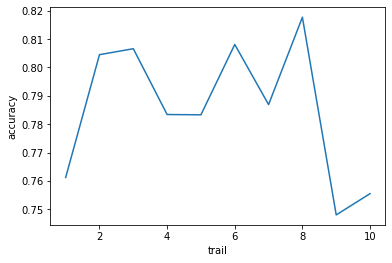

In [115]:
plt.plot(testing_df['trail'], testing_df['accuracy'])
plt.xlabel('trail')
plt.ylabel('accuracy')